In [1]:
import pickle
import numpy as np
import pandas as pd
from data import Stock
import matplotlib.cm as cm
from analysis import Analysis
import matplotlib.pyplot as plt
from hidden_markov_model import Hidden_Markov_Model

#### Data Retrieval And Display

In [2]:
sa40 = Stock('JTOPI', pd.read_csv('2015_2025_Historical_Data.csv'))
analysis = Analysis()

In [3]:
sa40.series_data

,Date,Price,Open,High,Low,Vol.,Return,Log_Return
1,2015-01-05,41990.24,43696.74,43882.81,41990.24,81.67,-0.039053,-0.039836
2,2015-01-06,42747.37,41990.24,42747.37,41983.39,78.48,0.018031,0.017870
3,2015-01-07,43086.35,42747.37,43159.91,42376.08,63.80,0.007930,0.007899
4,2015-01-08,43670.79,43086.35,43670.79,43020.22,76.25,0.013564,0.013473
5,2015-01-09,42994.58,43670.79,43785.33,42994.58,100.66,-0.015484,-0.015605
...,...,...,...,...,...,...,...,...
2494,2024-12-23,76067.93,75888.86,76277.36,75490.51,69.16,0.002360,0.002357
2495,2024-12-24,76320.99,76067.93,76588.19,75940.86,20.99,0.003327,0.003321
2496,2024-12-27,76197.46,76320.99,76603.50,75871.35,67.81,-0.001619,-0.001620
2497,2024-12-30,75427.05,76197.46,76221.20,75249.61,70.26,-0.010111,-0.010162


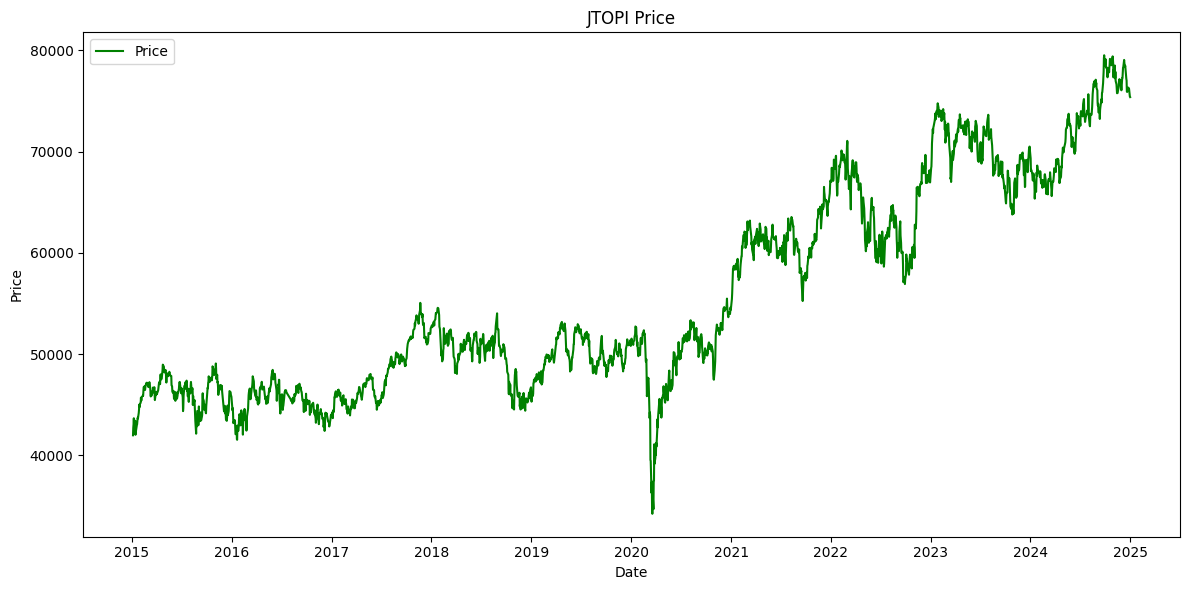

In [4]:
analysis.price_plot(sa40, 'Price')

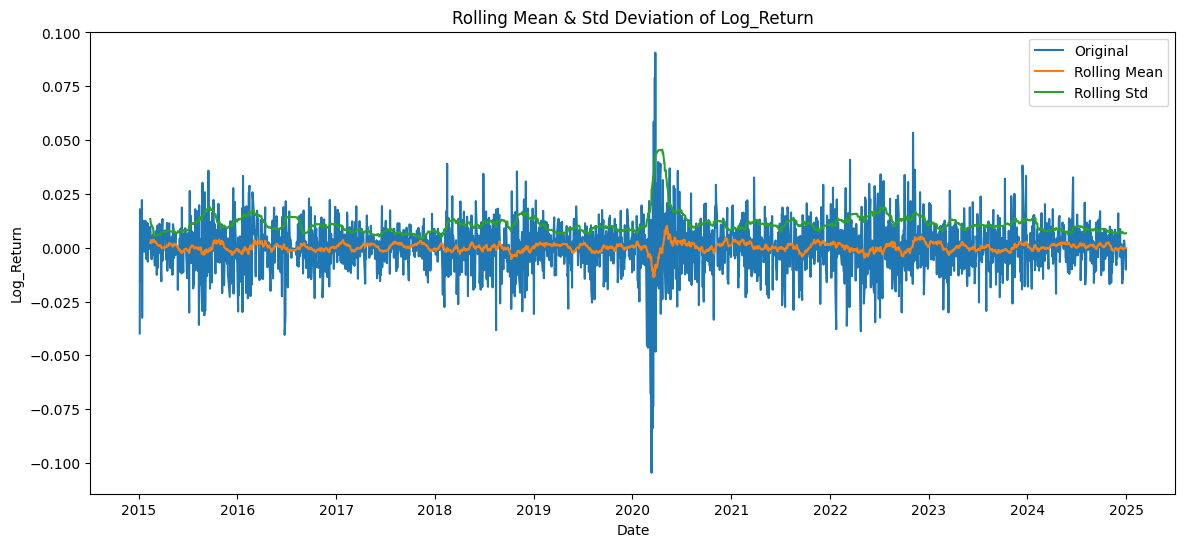

In [5]:
analysis.rolling_plot(sa40, 'Log_Return')

#### Two-State Model Specification And Training

In [6]:
two_state_model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 2)
two_state_model.baum_welch_algorithm(0.00001, 100)

Iteration 1 . . . Log-Likelihood = 7408.006836300501
Iteration 2 . . . Log-Likelihood = 7408.11904453277
Iteration 3 . . . Log-Likelihood = 7409.84466209062
Iteration 4 . . . Log-Likelihood = 7420.792833823198
Iteration 5 . . . Log-Likelihood = 7442.500010420987
Iteration 6 . . . Log-Likelihood = 7466.608524311614
Iteration 7 . . . Log-Likelihood = 7487.22953368723
Iteration 8 . . . Log-Likelihood = 7502.694211176995
Iteration 9 . . . Log-Likelihood = 7513.666314317248
Iteration 10 . . . Log-Likelihood = 7521.434815243845
Iteration 11 . . . Log-Likelihood = 7527.203039281194
Iteration 12 . . . Log-Likelihood = 7531.862909163273
Iteration 13 . . . Log-Likelihood = 7535.98130638387
Iteration 14 . . . Log-Likelihood = 7539.877476676309
Iteration 15 . . . Log-Likelihood = 7543.713958652888
Iteration 16 . . . Log-Likelihood = 7547.565635196006
Iteration 17 . . . Log-Likelihood = 7551.462058024254
Iteration 18 . . . Log-Likelihood = 7555.410200526931
Iteration 19 . . . Log-Likelihood = 7559.

In [7]:
two_state_model.get_parameters()

==================================== 0 =====================================
Initial Probability: 1.0
Mean: -0.0002813645025823344
Variance: 0.0003934343364927237


==================================== 1 =====================================
Initial Probability: 0.0
Mean: 0.0003762545583861801
Variance: 7.779207689991352e-05


Transition Matrix: [[0.92905072 0.07094928]
 [0.01779885 0.98220115]]
Log Likelihood: 7631.395100346701
Akaike Information Criterion: -3.8800519032933956
Bayesian Information Criterion: 36.7810532439174


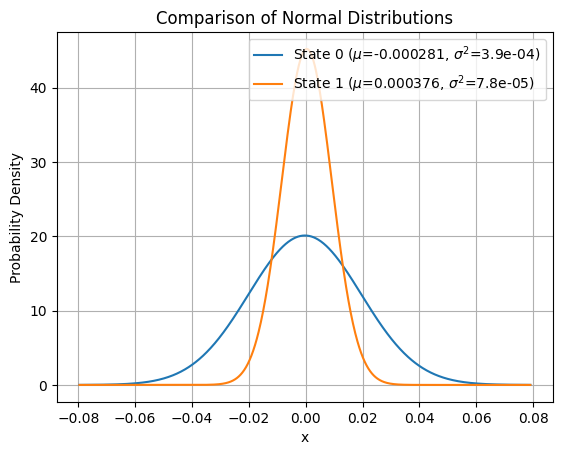

In [8]:
mean_array, variance_array = two_state_model.get_mean_variance()
analysis.plot_distributions(mean_array, variance_array)

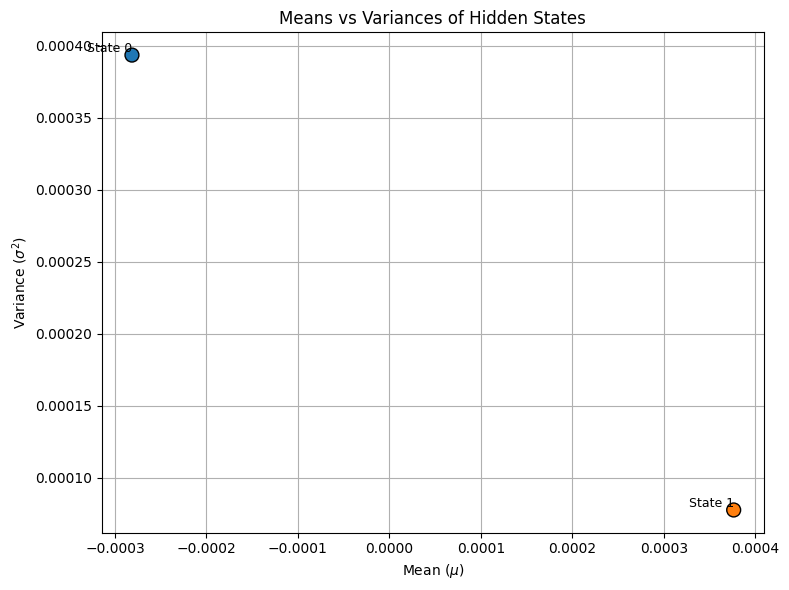

In [9]:
analysis.mean_variance_plot(mean_array, variance_array)

In [10]:
two_state_sequence = two_state_model.viterbi_algorithm()

/home/vmuser/Music/Gaussian-Hidden-Markov-Model/hidden_markov_model.py:170: RuntimeWarning: divide by zero encountered in log
  self.__state_vits[i].delta[0] = np.log(self.States[i].initial_probability) + emission_log_prob


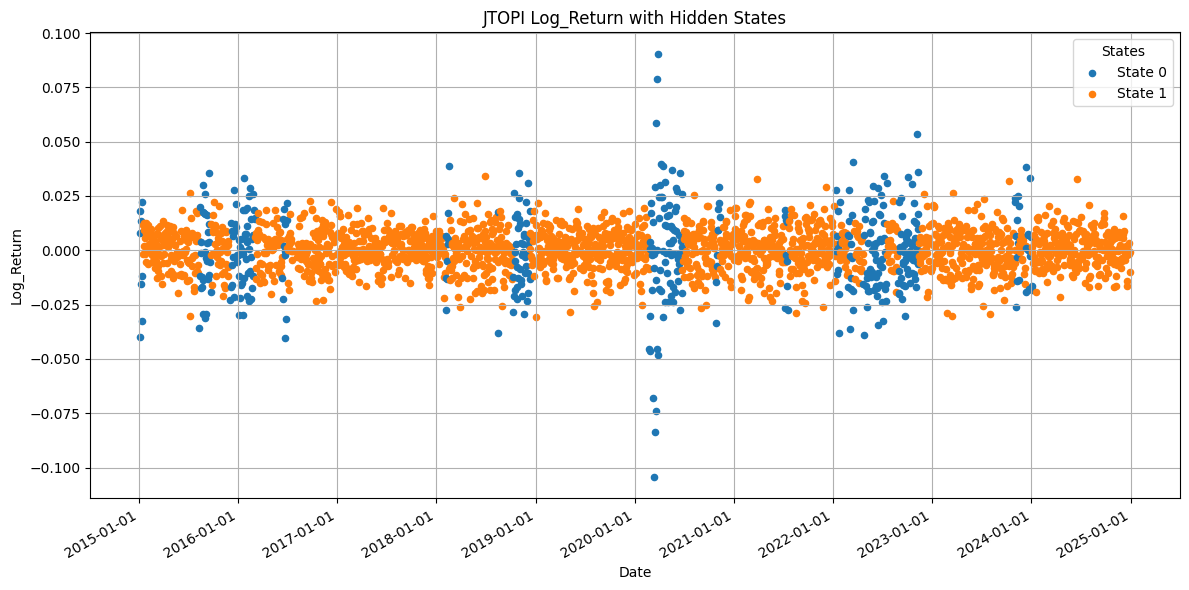

In [11]:
analysis.states_plot_points(sa40, 'Log_Return', two_state_sequence)

In [12]:
two_state_model.save_model('two_state_model')

HMM parameters saved to 'two_state_model.pkl'


#### Evaluate Model Against hmmlearn Model

In [27]:
import numpy as np
from hmmlearn import hmm

hmmlearn_two_state_model = hmm.GaussianHMM(n_components=2, covariance_type="diag", n_iter=100)
hmmlearn_two_state_model.fit(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

GaussianHMM(n_components=2, n_iter=100)

In [28]:
two_state_log_likelihood = hmmlearn_two_state_model.score(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))
def AIC(number_of_states, log_likelihood):
    number_of_parameters = (number_of_states * (number_of_states - 1)) + (2 * number_of_states) + (number_of_states - 1)
    return 2 * number_of_parameters - 2 * np.log(log_likelihood)

def BIC(number_of_states, log_likelihood):
    number_of_parameters = (number_of_states * (number_of_states - 1)) + (2 * number_of_states) + (number_of_states - 1)
    return number_of_parameters * np.log(len(sa40.series_data['Log_Return'].to_numpy())) - 2 * np.log(log_likelihood)

print(f'Akaike Information Criterion: {AIC(2, two_state_log_likelihood)}')
print(f'Bayesian Information Criterion: {BIC(2, two_state_log_likelihood)}')

Akaike Information Criterion: -3.878643575610031
Bayesian Information Criterion: 36.78246157160076


In [29]:
hmmlearn_two_state_sequence = hmmlearn_two_state_model.predict(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

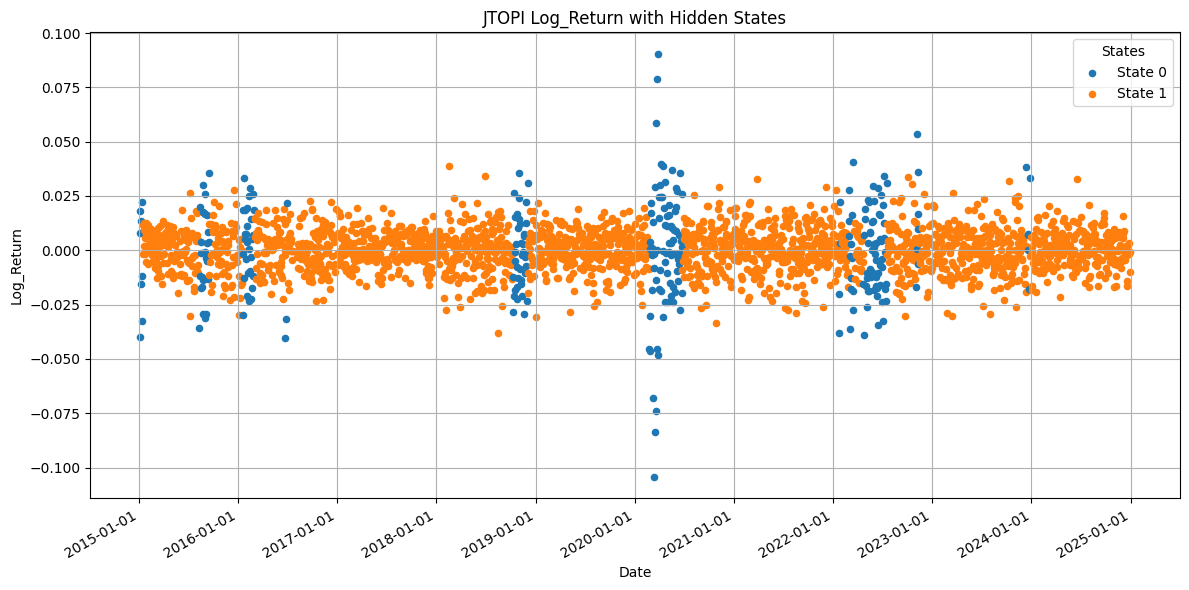

In [30]:
analysis.states_plot_points(sa40, 'Log_Return', hmmlearn_two_state_sequence)

#### Four-State Model Specification And Training

In [44]:
three_state_model = Hidden_Markov_Model(sa40.series_data['Log_Return'].to_numpy(), 3)
three_state_model.baum_welch_algorithm(0.00001, 100)

Iteration 1 . . . Log-Likelihood = 7408.084892055391
Iteration 2 . . . Log-Likelihood = 7410.000340553106
Iteration 3 . . . Log-Likelihood = 7434.236514748058
Iteration 4 . . . Log-Likelihood = 7492.838569210145
Iteration 5 . . . Log-Likelihood = 7533.215006093322
Iteration 6 . . . Log-Likelihood = 7550.184639436519
Iteration 7 . . . Log-Likelihood = 7557.597585148496
Iteration 8 . . . Log-Likelihood = 7562.2740990000275
Iteration 9 . . . Log-Likelihood = 7566.203495406149
Iteration 10 . . . Log-Likelihood = 7569.869601268257
Iteration 11 . . . Log-Likelihood = 7573.396056483964
Iteration 12 . . . Log-Likelihood = 7576.825315009402
Iteration 13 . . . Log-Likelihood = 7580.177507822429
Iteration 14 . . . Log-Likelihood = 7583.462462683805
Iteration 15 . . . Log-Likelihood = 7586.683071275736
Iteration 16 . . . Log-Likelihood = 7589.837742304402
Iteration 17 . . . Log-Likelihood = 7592.923179652358
Iteration 18 . . . Log-Likelihood = 7595.937183601802
Iteration 19 . . . Log-Likelihood = 

In [45]:
three_state_model.get_parameters()

==================================== 0 =====================================
Initial Probability: 0.0
Mean: -0.00015813632006270027
Variance: 0.0001038401193796276


==================================== 1 =====================================
Initial Probability: 1.0
Mean: -7.50505537735238e-05
Variance: 0.0004479966113974181


==================================== 2 =====================================
Initial Probability: 0.0
Mean: 0.0017828751760254173
Variance: 2.7291838047716787e-05


Transition Matrix: [[7.38789062e-01 1.43436797e-02 2.46867258e-01]
 [6.20305376e-02 9.37714074e-01 2.55387978e-04]
 [7.99773847e-01 4.36532357e-06 2.00221788e-01]]
Log Likelihood: 7641.658399926577
Akaike Information Criterion: 10.117260146684156
Bayesian Information Criterion: 91.43947044110575


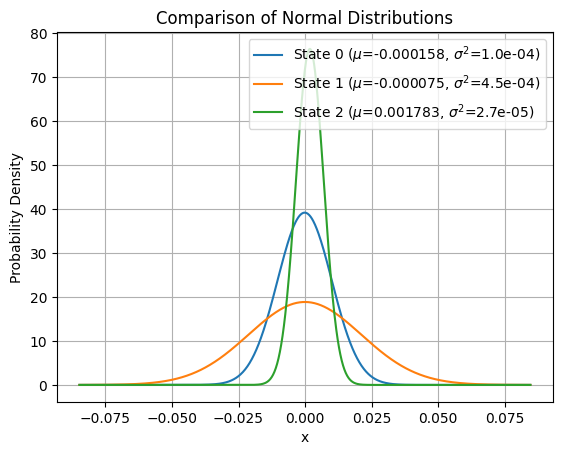

In [46]:
mean_array, variance_array = three_state_model.get_mean_variance()
analysis.plot_distributions(mean_array, variance_array)

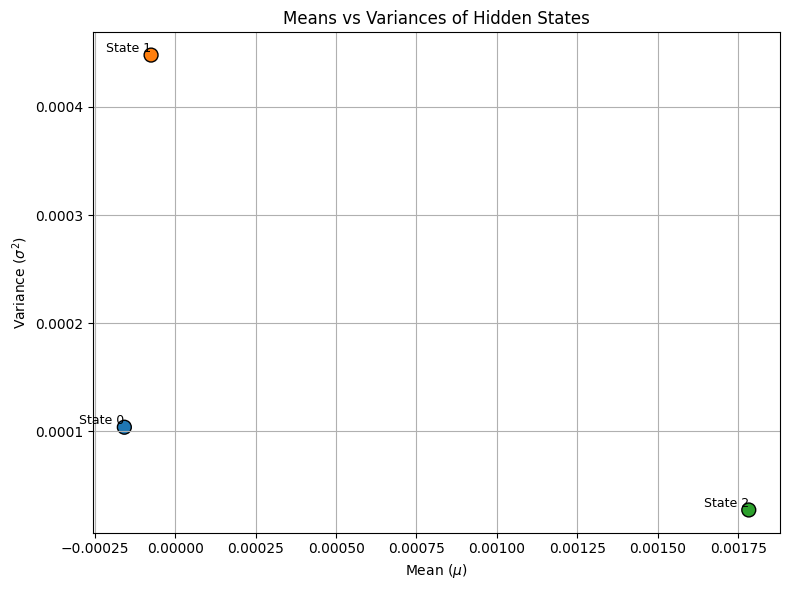

In [47]:
analysis.mean_variance_plot(mean_array, variance_array)

In [49]:
three_state_sequence = three_state_model.viterbi_algorithm()

In [ ]:
analysis.states_plot_points(sa40, 'Log_Return', three_state_sequence)

In [36]:
three_state_model.save_model('three_state_model')

HMM parameters saved to 'three_state_model.pkl'


#### Evaluate Model Against hmmlearn Model

In [39]:
import numpy as np
from hmmlearn import hmm

hmmlearn_three_state_model = hmm.GaussianHMM(n_components=3, covariance_type="diag", n_iter=100)
hmmlearn_three_state_model.fit(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

GaussianHMM(n_components=3, n_iter=100)

In [41]:
three_state_log_likelihood = hmmlearn_three_state_model.score(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))
print(f'Akaike Information Criterion: {AIC(3, three_state_log_likelihood)}')
print(f'Bayesian Information Criterion: {BIC(3, three_state_log_likelihood)}')

Akaike Information Criterion: 10.119622671494717
Bayesian Information Criterion: 91.44183296591632


In [42]:
hmmlearn_three_state_sequence = hmmlearn_three_state_model.predict(sa40.series_data['Log_Return'].to_numpy().reshape(-1,1))

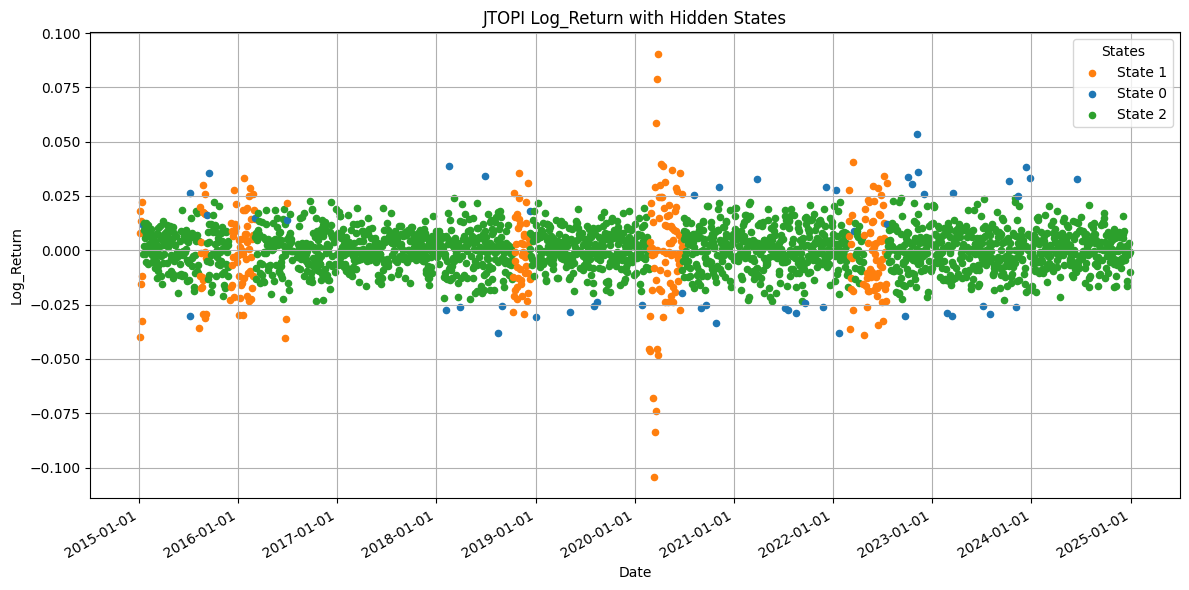

In [43]:
analysis.states_plot_points(sa40, 'Log_Return', hmmlearn_three_state_sequence)